# K-Nearest Neighbors (KNN): Learn by Running Cells

This notebook is built from the GeeksforGeeks KNN article plus official scikit-learn examples/docs.

Audience:
- Students learning supervised ML from scratch and with scikit-learn.

Prerequisites:
- Basic Python, arrays/lists, and train/test split idea.
- Very basic understanding of classification vs regression.

Learning goals:
- Explain what KNN is and why it is called a *lazy learner*.
- Implement KNN classification and regression from scratch.
- Tune `k` with cross-validation.
- Understand why feature scaling is critical for KNN.
- Evaluate KNN with accuracy, F1, and confusion matrix.
- See the curse of dimensionality in code.

How to use this notebook:
- Code cells are designed to be self-contained so you can run them individually.
- Run top-to-bottom once, then jump back and experiment.
        


## Outline

1. Environment check
2. KNN intuition on a tiny dataset
3. Distance metrics (Euclidean, Manhattan, Minkowski)
4. KNN from scratch (classification + regression)
5. Choosing `k` with cross-validation
6. Why scaling matters (real dataset)
7. Decision boundaries and `weights`
8. Evaluation metrics
9. Curse of dimensionality demo
10. Pitfalls, best practices, and exercises
        


In [1]:
from importlib.util import find_spec
import sys

required = ["numpy", "pandas", "matplotlib", "seaborn", "sklearn"]
missing = [pkg for pkg in required if find_spec(pkg) is None]

print("Python version:", sys.version.split()[0])
if missing:
    print("Missing packages:", ", ".join(missing))
    print("Install with: pip install " + " ".join(missing))
else:
    print("All required packages are installed.")
        


Python version: 3.12.11
All required packages are installed.


## 1) KNN intuition: classify by nearby points

KNN predicts a new point by looking at the labels of its nearest neighbors.

- For classification: vote (majority class).
- For regression: average the neighbor target values.

Key idea from GeeksforGeeks:
- Small `k` -> flexible but noise-sensitive (high variance).
- Large `k` -> smoother but can miss local patterns (high bias).
        


In [2]:
import numpy as np
from collections import Counter

# Tiny 2D training set: two classes A and B
X_train = np.array([
    [1.0, 1.0],
    [1.5, 1.8],
    [2.0, 1.0],
    [6.0, 5.0],
    [7.0, 7.0],
    [8.0, 6.0],
])
y_train = np.array(["A", "A", "A", "B", "B", "B"])

x_query = np.array([3.0, 2.5])

def euclidean(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def knn_vote(X, y, query, k=3):
    distances = np.array([euclidean(query, row) for row in X])
    nn_idx = np.argsort(distances)[:k]
    nn_labels = y[nn_idx]
    pred = Counter(nn_labels).most_common(1)[0][0]
    return pred, nn_idx, distances

for k in [1, 3, 5]:
    pred, idx, d = knn_vote(X_train, y_train, x_query, k=k)
    print(f"k={k} -> prediction={pred}")
    print("  nearest labels:", y_train[idx].tolist())
    print("  nearest distances:", np.round(d[idx], 3).tolist())
        


k=1 -> prediction=A
  nearest labels: ['A']
  nearest distances: [1.655]
k=3 -> prediction=A
  nearest labels: ['A', 'A', 'A']
  nearest distances: [1.655, 1.803, 2.5]
k=5 -> prediction=A
  nearest labels: ['A', 'A', 'A', 'B', 'B']
  nearest distances: [1.655, 1.803, 2.5, 3.905, 6.021]


## 2) Distance metrics used in KNN

GeeksforGeeks highlights three common metrics:

- Euclidean distance (`p=2`): straight-line distance.
- Manhattan distance (`p=1`): grid/taxicab distance.
- Minkowski distance (`p`): general form including both above.

Formula:
\[
D(\mathbf{x},\mathbf{z}) = \left(\sum_i |x_i-z_i|^p\right)^{1/p}
\]


In [3]:
import numpy as np

x = np.array([2.0, -1.0, 3.0])
z = np.array([0.0,  2.0, 1.0])

def minkowski(a, b, p=2):
    return np.sum(np.abs(a - b) ** p) ** (1 / p)

print("Euclidean (p=2):", round(minkowski(x, z, p=2), 4))
print("Manhattan (p=1):", round(minkowski(x, z, p=1), 4))
print("Minkowski (p=3):", round(minkowski(x, z, p=3), 4))
        


Euclidean (p=2): 4.1231
Manhattan (p=1): 7.0
Minkowski (p=3): 3.5034


## 3) KNN algorithm steps and cost

For each query point:
1. Compute distance to every training point (`O(n * d)`).
2. Sort/select nearest `k` neighbors.
3. Aggregate neighbor targets (vote or average).

Why KNN is called a lazy learner:
- It does almost no work during `fit` (stores data).
- Most computation happens at prediction time.
        


In [4]:
import numpy as np
from collections import Counter

class SimpleKNNClassifier:
    def __init__(self, k=3, p=2, weights="uniform"):
        if k < 1:
            raise ValueError("k must be >= 1")
        if weights not in {"uniform", "distance"}:
            raise ValueError("weights must be 'uniform' or 'distance'")
        self.k = k
        self.p = p
        self.weights = weights
        self.X_train = None
        self.y_train = None

    def _distance(self, a, b):
        return np.sum(np.abs(a - b) ** self.p) ** (1 / self.p)

    def fit(self, X, y):
        self.X_train = np.asarray(X, dtype=float)
        self.y_train = np.asarray(y)
        return self

    def predict_one(self, x):
        x = np.asarray(x, dtype=float)
        dists = np.array([self._distance(x, row) for row in self.X_train])
        idx = np.argsort(dists)[: self.k]
        labels = self.y_train[idx]

        if self.weights == "uniform":
            return Counter(labels).most_common(1)[0][0]

        # distance weighting: closer neighbors get bigger vote
        eps = 1e-9
        w = 1 / (dists[idx] + eps)
        vote = {}
        for label, weight in zip(labels, w):
            vote[label] = vote.get(label, 0.0) + float(weight)
        return max(vote.items(), key=lambda t: t[1])[0]

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        return np.array([self.predict_one(x) for x in X])

# Demo on a toy dataset
X_train = np.array([
    [1, 2], [2, 3], [3, 4],
    [7, 8], [8, 9], [9, 9],
], dtype=float)
y_train = np.array(["A", "A", "A", "B", "B", "B"])
X_test = np.array([[4, 5], [8, 8], [2, 2]])

clf = SimpleKNNClassifier(k=3, p=2, weights="uniform").fit(X_train, y_train)
print("Predictions (uniform):", clf.predict(X_test).tolist())

clf_w = SimpleKNNClassifier(k=3, p=2, weights="distance").fit(X_train, y_train)
print("Predictions (distance):", clf_w.predict(X_test).tolist())
        


Predictions (uniform): ['A', 'B', 'A']
Predictions (distance): ['A', 'B', 'A']


## 4) KNN for regression (average of nearest targets)

For regression, KNN returns the mean (or distance-weighted mean) of neighbor target values.
        


In [5]:
import numpy as np

class SimpleKNNRegressor:
    def __init__(self, k=3, p=2, weights="uniform"):
        if k < 1:
            raise ValueError("k must be >= 1")
        if weights not in {"uniform", "distance"}:
            raise ValueError("weights must be 'uniform' or 'distance'")
        self.k = k
        self.p = p
        self.weights = weights

    def _distance(self, a, b):
        return np.sum(np.abs(a - b) ** self.p) ** (1 / self.p)

    def fit(self, X, y):
        self.X_train = np.asarray(X, dtype=float)
        self.y_train = np.asarray(y, dtype=float)
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        preds = []
        for x in X:
            dists = np.array([self._distance(x, row) for row in self.X_train])
            idx = np.argsort(dists)[: self.k]
            vals = self.y_train[idx]

            if self.weights == "uniform":
                preds.append(float(np.mean(vals)))
            else:
                eps = 1e-9
                w = 1 / (dists[idx] + eps)
                preds.append(float(np.sum(w * vals) / np.sum(w)))
        return np.array(preds)

# Synthetic 1D regression data
rng = np.random.default_rng(42)
X_train = np.linspace(0, 10, 25).reshape(-1, 1)
y_train = np.sin(X_train[:, 0]) + rng.normal(0, 0.15, size=len(X_train))

X_query = np.array([[1.5], [4.0], [8.2]])
reg = SimpleKNNRegressor(k=5, p=2, weights="distance").fit(X_train, y_train)
print("Query points:", X_query[:, 0].tolist())
print("Predictions:", np.round(reg.predict(X_query), 4).tolist())
        


Query points: [1.5, 4.0, 8.2]
Predictions: [0.8184, -0.6946, 0.8409]


## 5) How to choose `k`: cross-validation beats guessing

Common practical flow (also emphasized in GeeksforGeeks):
- Try a range of `k` values.
- Use cross-validation.
- Pick the `k` with strongest average validation performance.

Notes:
- Use odd `k` for binary/multi-class majority-vote tasks to reduce tie chances.
- Reasonable initial range: `k=1` to `k=30` (then expand if needed).
        


Best k by CV accuracy: 5
Mean CV accuracy: 0.9733 (+/- 0.0249)


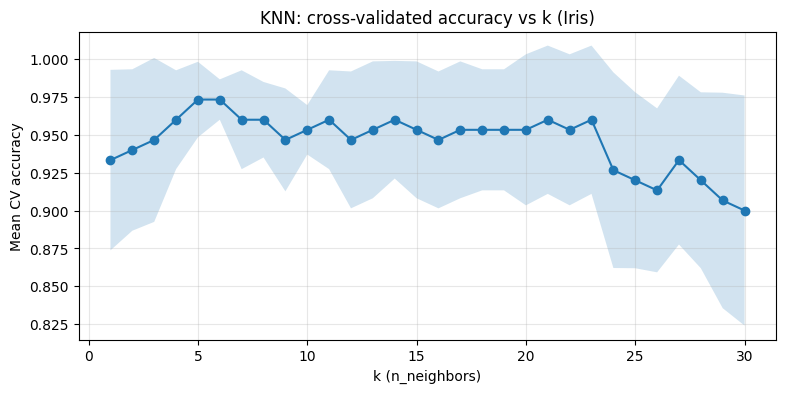

,k,mean_accuracy,std
4,5,0.973333,0.024944
5,6,0.973333,0.013333
22,23,0.960000,0.048990
13,14,0.960000,0.038873
20,21,0.960000,0.048990
3,4,0.960000,0.032660
6,7,0.960000,0.032660
7,8,0.960000,0.024944
10,11,0.960000,0.032660
21,22,0.953333,0.049889


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X, y = load_iris(return_X_y=True)
k_values = range(1, 31)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
for k in k_values:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k)),
    ])
    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    rows.append({
        "k": k,
        "mean_accuracy": scores.mean(),
        "std": scores.std(),
    })

results = pd.DataFrame(rows)
best = results.loc[results["mean_accuracy"].idxmax()]
print(f"Best k by CV accuracy: {int(best['k'])}")
print(f"Mean CV accuracy: {best['mean_accuracy']:.4f} (+/- {best['std']:.4f})")

plt.figure(figsize=(9, 4))
plt.plot(results["k"], results["mean_accuracy"], marker="o")
plt.fill_between(
    results["k"],
    results["mean_accuracy"] - results["std"],
    results["mean_accuracy"] + results["std"],
    alpha=0.2,
)
plt.title("KNN: cross-validated accuracy vs k (Iris)")
plt.xlabel("k (n_neighbors)")
plt.ylabel("Mean CV accuracy")
plt.grid(alpha=0.3)
plt.show()

results.sort_values("mean_accuracy", ascending=False).head(10)
        


## 6) Why scaling matters so much for KNN

scikit-learn explicitly warns that KNN distance-based models are strongly affected by feature scale.

If one feature has values 100x larger than another, it can dominate distance calculations.
So we usually use `StandardScaler` before KNN.
        


In [7]:
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X, y = load_wine(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

unscaled = KNeighborsClassifier(n_neighbors=11)
unscaled.fit(X_train, y_train)
unscaled_acc = accuracy_score(y_test, unscaled.predict(X_test))

scaled = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=11)),
])
scaled.fit(X_train, y_train)
scaled_acc = accuracy_score(y_test, scaled.predict(X_test))

pd.DataFrame(
    {
        "model": ["KNN (unscaled)", "KNN (StandardScaler + KNN)"],
        "test_accuracy": [unscaled_acc, scaled_acc],
    }
)
        


,model,test_accuracy
0,KNN (unscaled),0.733333
1,KNN (StandardScaler + KNN),0.977778


## 7) `weights='uniform'` vs `weights='distance'`

From scikit-learn docs:
- `uniform`: all k neighbors count equally.
- `distance`: closer neighbors get larger influence.

Let's visualize decision boundaries for both on Iris (2 features).
        


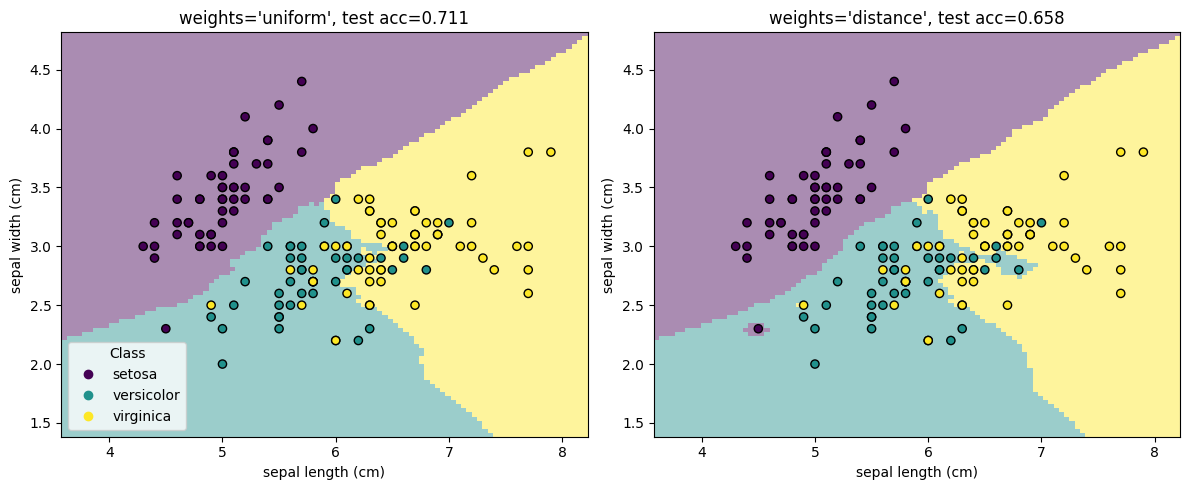

In [8]:
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

iris = load_iris(as_frame=True)
X = iris.data[["sepal length (cm)", "sepal width (cm)"]]
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=0
)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, weights in zip(axes, ["uniform", "distance"]):
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=11, weights=weights)),
    ])
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)

    DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test,
        response_method="predict",
        plot_method="pcolormesh",
        alpha=0.45,
        ax=ax,
    )
    scatter = ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolor="k", s=35)
    ax.set_title(f"weights='{weights}', test acc={acc:.3f}")
    ax.set_xlabel(X.columns[0])
    ax.set_ylabel(X.columns[1])

handles, _ = scatter.legend_elements()
axes[0].legend(handles, iris.target_names, title="Class", loc="lower left")
plt.tight_layout()
plt.show()
        


## 8) Full evaluation: accuracy, macro-F1, confusion matrix

Never trust a single metric.
- Accuracy: overall correctness.
- Macro-F1: balances precision/recall across classes equally.
- Confusion matrix: where errors happen.
        


Accuracy: 0.9737
Macro-F1: 0.9733

Classification report:

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       1.00      0.92      0.96        13
   virginica       0.92      1.00      0.96        12

    accuracy                           0.97        38
   macro avg       0.97      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38



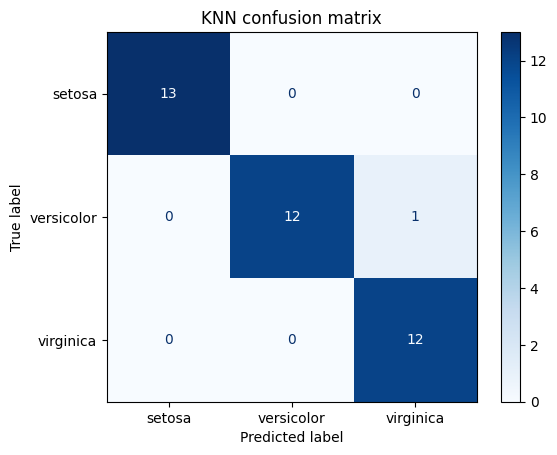

In [9]:
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    f1_score,
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=7
)

model = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=11, weights="distance")),
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("Macro-F1:", round(f1_score(y_test, y_pred, average="macro"), 4))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=iris.target_names))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=iris.target_names,
    cmap="Blues",
)
plt.title("KNN confusion matrix")
plt.show()


## 9) Curse of dimensionality (quick simulation)

As feature dimension grows, nearest and farthest distances can become relatively similar.
This makes "nearest" less informative and can hurt KNN.

Below we estimate the ratio:
\[
\text{ratio} = \frac{d_{min}}{d_{max}}
\]

A ratio closer to 1 means distances are concentrating.


   dimension  min_dist  max_dist  min_over_max
0          2  0.008146  1.028658      0.007919
1          5  0.193861  1.582255      0.122522
2         10  0.426867  2.100445      0.203227
3         20  0.936278  2.668018      0.350927
4         50  2.010350  3.491576      0.575772
5        100  3.240804  4.876389      0.664591
6        200  4.865007  6.610422      0.735960


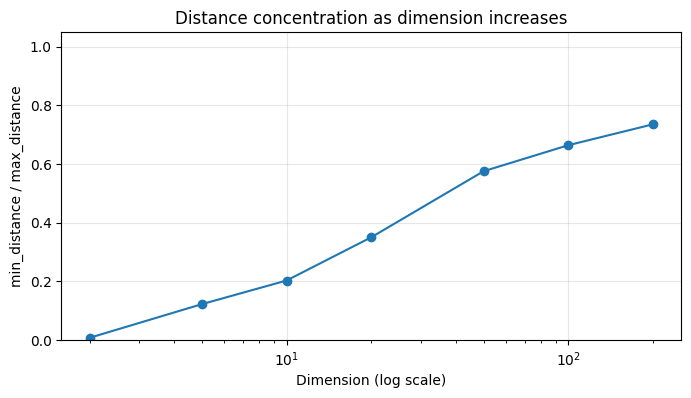

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)
dims = [2, 5, 10, 20, 50, 100, 200]
n_points = 3000

rows = []
for d in dims:
    X = rng.random((n_points, d))
    q = rng.random(d)
    dists = np.linalg.norm(X - q, axis=1)
    rows.append(
        {
            "dimension": d,
            "min_dist": float(dists.min()),
            "max_dist": float(dists.max()),
            "min_over_max": float(dists.min() / dists.max()),
        }
    )

df = pd.DataFrame(rows)
print(df)

plt.figure(figsize=(8, 4))
plt.plot(df["dimension"], df["min_over_max"], marker="o")
plt.xscale("log")
plt.ylim(0, 1.05)
plt.title("Distance concentration as dimension increases")
plt.xlabel("Dimension (log scale)")
plt.ylabel("min_distance / max_distance")
plt.grid(alpha=0.3)
plt.show()
        


## 10) Pitfalls and best practices

Common mistakes:
- Forgetting feature scaling before KNN.
- Choosing `k` once and never validating it.
- Evaluating only on training data.
- Using KNN directly on very high-dimensional noisy features.

Practical defaults:
- Start with a `Pipeline([StandardScaler(), KNeighborsClassifier()])`.
- Search `k` with cross-validation.
- Try both `weights='uniform'` and `weights='distance'`.
- If dimensionality is high, test PCA before KNN.
        


## 11) Exercises (try these)

1. On Iris, compare `p=1` (Manhattan) vs `p=2` (Euclidean). Which scores better?
2. Run grid search for `k` from 1..40 with and without scaling.
3. Add PCA before KNN and compare runtime + accuracy on Wine.
4. Modify the scratch classifier to break ties by nearest neighbor distance.
        


In [11]:
# Exercise scaffold (runnable as-is, then edit)
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X, y = load_iris(return_X_y=True)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for p in [1, 2]:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=11, p=p)),
    ])
    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    print(f"p={p}: mean accuracy={scores.mean():.4f} +/- {scores.std():.4f}")

# TODO:
# - Change n_neighbors and compare.
# - Remove StandardScaler and observe effect.
# - Add weights='distance' and compare.
        


p=1: mean accuracy=0.9467 +/- 0.0400
p=2: mean accuracy=0.9600 +/- 0.0327


## References used for this notebook

- GeeksforGeeks: K-Nearest Neighbor (KNN) Algorithm  
  https://www.geeksforgeeks.org/machine-learning/k-nearest-neighbours/
- scikit-learn API: `KNeighborsClassifier`  
  https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
- scikit-learn example: Importance of Feature Scaling  
  https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html
- scikit-learn example: Nearest Neighbors Classification  
  https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
        
